# Adjustment Analysis

This notebook contains experiments for analyzing the drivers of whether privacy adjusted forecasts are better or worse than their original counterparts. The use of random forest and decision trees is motivated by the work of [Naghmeh et al. (2022).](https://www.sciencedirect.com/science/article/abs/pii/S0377221722002260)

# In the random forest, do a version with indicators for model and protection type, and a version without for aggregate results.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
# plt.rcParams['figure.figsize'] = [20, 15]
import os

from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.utils.plotting import plot_series

from tsfeatures import tsfeatures

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree

import graphviz 

The first step is to classify the adjusted forecasts as valuable or not (improved accuracy or not) and then extract a large number of adjustment and time series features to predict the `valuable` variable.

Start with defining the path where results will be saved, and the path to the forecast files. 

In [2]:
# results file path
results_path = "../../Outputs/Results/"
# forecasts file path
forecasts_path = "../../Outputs/Forecasts/"
# names of forecast files
fcast_files = os.listdir(forecasts_path)

Read in the train and test data for $h = 1$.

In [3]:
train_data = pd.read_csv("../../Data/Train/Clean/m3_monthly_micro_h1.csv", header=None, skiprows=1)
# convert to a list of series, and drop missing values
train_data = [x.dropna() for _, x in train_data.iterrows()]
test_data = pd.read_csv(forecasts_path + "Test_h1.csv")

***

# Import Time Series Characteristics

Now, we write a loop to read in the time series features, the original forecasts, and the protected forecasts for each model and dataset. We calculate whether the adjustment was valuable based on the forecast errors, add this to the features, and combine all of these dataframes into one.

In [4]:
files = os.listdir("../../Data/Train/Clean/tsfeatures")

Extract only the files for $h = 1$ and for Top coding.

In [5]:
files = [f for f in files if "h1_" in f and "k-nts" not in f]

In [6]:
fcast_files = [f for f in fcast_files if "h1_" in f and "m3_original" not in f and "k_nts" not in f]

Now we have lists of the feature files and the forecast files.

In [7]:
models = ["SES", "DES", "TES", "ARIMA", "VAR", "Multivariate_LGBM", "RNN"]

In [87]:
ts_features = pd.read_csv("../../Data/Train/Clean/tsfeatures/tsfeatures_h1.csv")

In [89]:
np.min(ts_features.hurst)

0.500045830129239

In [90]:
np.max(ts_features.hurst)

0.998999598195642

In [9]:
ts_features = np.abs(ts_features)

In [10]:
full_data = []
# for each file with time series features
for f in files:
    ts_features_protected = np.abs(pd.read_csv("../../Data/Train/Clean/tsfeatures/" + f))
    feature_diffs = ts_features - ts_features_protected
    # for each forecasting model
    for m in models:
        # get the name of the file with the protected forecasts for the model
        fcast_file = [fcasts for fcasts in fcast_files if f in fcasts and m in fcasts]
        [fcast_file] = fcast_file
        # import the privacy adjusted forecasts
        fcasts_protected = pd.read_csv(forecasts_path + fcast_file)
        # import the original forecasts
        fcasts_original = pd.read_csv(forecasts_path + m + "_h1_original.csv")
        # calculate original MAE
        original_errors = mean_absolute_error(test_data, fcasts_original, multioutput="raw_values")
        # calculate protected MAE
        adjusted_errors = mean_absolute_error(test_data, fcasts_protected, multioutput="raw_values")
        # calculate whether the adjustment improved accuracy
        valuable = adjusted_errors < original_errors
        
        combined = pd.concat([feature_diffs, pd.Series(valuable, name='valuable'), pd.Series(np.repeat(m, len(valuable)), name='model'), pd.Series(feature_diffs.index, name="original_series")], axis=1)
        
        full_data.append(combined)

In [11]:
full_data = pd.concat(full_data, axis=0).reset_index(drop=True)

In [12]:
full_data

,series_mean,series_variance,entropy,stability,lumpiness,max_level_shift,time_level_shift,max_var_shift,time_var_shift,max_kl_shift,...,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,nonlinearity,valuable,model,original_series
0,0.459075,-3.618455,-0.031703,0.163650,-0.920658,-0.970139,15,-9.377682,28,-34.432373,...,0.188492,0.044066,0.053093,0.014978,0.040755,0.002605,-0.041006,True,SES,0
1,0.400392,-2.885622,0.000000,-0.048443,-1.113314,-1.117344,2,-6.731426,-10,-7.934486,...,0.015951,-0.092287,-0.201130,-0.055909,-0.190957,-0.079814,-0.039702,False,SES,1
2,0.046779,-0.164079,-0.059254,0.104042,-0.315271,-0.059936,0,-0.385103,0,-0.787156,...,0.300568,0.006736,0.063653,0.017297,0.095153,0.025769,0.003036,True,SES,2
3,0.422581,-3.127755,-0.087785,0.367855,-0.794671,-0.809231,0,-7.821573,-13,-3.632079,...,1.440058,0.026277,-0.106059,-0.014490,-0.265756,0.223338,-0.124772,False,SES,3
4,0.063042,-0.332426,-0.051145,0.086886,-0.491970,-0.156039,2,-0.660888,3,-2.397004,...,0.335359,-0.030536,-0.119088,-0.006634,-0.096981,0.123247,0.172501,True,SES,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49765,0.033281,0.005803,0.237188,0.043805,-0.203502,0.038292,1,0.008229,-7,0.410619,...,0.311019,0.105289,0.000651,0.044451,-0.097926,-0.064641,0.186451,False,RNN,469
49766,0.005801,0.000296,0.002190,0.071287,-0.035114,0.005480,-48,0.000199,37,-0.296223,...,0.076957,-0.104524,-0.174285,-0.080151,-0.279228,-0.003533,0.175199,True,RNN,470
49767,0.030024,0.004845,0.098819,-0.129925,0.164607,0.068698,0,0.007060,-2,1.480214,...,-0.507695,0.012650,0.049103,-0.052857,-0.088141,-0.141969,-0.617745,True,RNN,471
49768,0.005286,0.000223,-0.021327,0.018810,0.796254,0.017636,-29,0.001026,-15,11.232731,...,0.097035,0.013598,0.192291,-0.015761,0.193426,0.107589,-0.025163,True,RNN,472


In [13]:
full_data.columns

Index(['series_mean', 'series_variance', 'entropy', 'stability', 'lumpiness',
       'max_level_shift', 'time_level_shift', 'max_var_shift',
       'time_var_shift', 'max_kl_shift', 'time_kl_shift', 'crossing_points',
       'flat_spots', 'hurst', 'nperiods', 'seasonal_period', 'trend', 'spike',
       'linearity', 'curvature', 'e_acf1', 'e_acf10', 'seasonal_strength',
       'peak', 'trough', 'x_acf1', 'x_acf10', 'diff1_acf1', 'diff1_acf10',
       'diff2_acf1', 'diff2_acf10', 'seas_acf1', 'nonlinearity', 'valuable',
       'model', 'original_series'],
      dtype='object')

In [14]:
full_data = full_data.drop(["nperiods", "seasonal_period", "model", "time_level_shift", "time_var_shift", "time_kl_shift",
                            "e_acf10", "x_acf10", "diff1_acf1", "diff1_acf10", "diff2_acf1", "diff2_acf10"], axis=1)

# Calculate Forecast Characteristics

We want to calculate adjustment variables for each protection method across all models and protection parameters.

We will need to loop through forecast files.

In [15]:
protection_methods = {"Top": [0.1, 0.2, 0.4],
                      "Bottom": [0.1, 0.2, 0.4], 
                      "AN": [0.5, 1, 1.5, 2],
                      "DP": [0.1, 1, 4.6, 10, 20]}

# Need to concatenate dataframes so index will line up.

In [16]:
forecast_characteristics = []

# for each model
for model in models:
    
    # import the original forecasts
    original_file = [f for f in fcast_files if model in f and 'original' in f]
    [original_file] = original_file
    original_fcasts = pd.read_csv(forecasts_path + original_file)
    
    # for each protection method
    for method in protection_methods.items():
        
        # for each parameter
        for param in method[1]:
            
            # import the forecasts based on protected data
            protected_file = [f for f in fcast_files if method[0] in f and "_"+str(param)+".csv" in f and model in f]
            
            [protected_file] = protected_file
            
            # import each protected file and calculate characteristics
            protected_fcasts = pd.read_csv(forecasts_path + protected_file)
            
            # adjustment direction
            direction = (protected_fcasts > original_fcasts).T
            
            # Calculate adjustment magnitude (absolute difference in forecasts), normalized by the mean of the series.
            series_means = [np.mean(x) for x in train_data]
            magnitudes = (protected_fcasts - original_fcasts).abs().T.divide(series_means, axis=0)

            # Calculate binary large and small adjustment indicators (belongs to 4th and 1st quantiles, respectively).
            # qs = np.quantile(magnitudes, q=[0.25, 0.75])
            # large_magnitudes = magnitudes >= qs[1]
            # small_magnitudes = magnitudes <= qs[0]
            
            # calculate original MAE
            original_errors = mean_absolute_error(test_data, original_fcasts, multioutput="raw_values")
            # calculate protected MAE
            adjusted_errors = mean_absolute_error(test_data, protected_fcasts, multioutput="raw_values")
            # calculate whether the adjustment improved accuracy
            valuable = pd.Series(adjusted_errors < original_errors)
            
            # indicators for the protection method, parameter, and model
            method_col = pd.Series(np.repeat(method[0], len(train_data))).reset_index(drop=True)
            param_col = pd.Series(np.repeat(str(param), len(train_data))).reset_index(drop=True)
            model_col = pd.Series(np.repeat(model, len(train_data))).reset_index(drop=True)
            
            # concatenate adjustment variables separately and reset the index
            X = pd.concat([direction, magnitudes], ignore_index=True, axis=1).reset_index(drop=True)
            
            # separate concatenations because the index was getting messed up
            X = pd.concat([method_col, param_col, model_col, X, valuable], axis=1)
            
            X.columns = ["Method", "Parameter", "Model", "Direction", "Magnitude", "Valuable"]
            
            forecast_characteristics.append(X)

In [17]:
adjustment_df = pd.concat(forecast_characteristics, axis=0)

In [18]:
adjustment_df.loc[adjustment_df.Method=="Top",:].mean()

Direction    0.374623
Magnitude    0.047343
Valuable     0.519892
dtype: float64

In [19]:
adjustment_df.loc[adjustment_df.Method=="Top",:].groupby(["Direction"]).mean()

,Magnitude,Valuable
Direction,,
False,0.060653,0.486586
True,0.025124,0.575489


In [20]:
adjustment_df.loc[adjustment_df.Method=="Top",:].groupby(["Parameter"]).mean()

,Direction,Magnitude,Valuable
Parameter,,,
0.1,0.414406,0.022905,0.536468
0.2,0.379747,0.041751,0.522604
0.4,0.329717,0.077373,0.500603


Include top and bottom adjustment results with k-nts adjustment results.

In [21]:
adjustment_df.loc[adjustment_df.Method=="Top",:].groupby(["Direction", "Parameter"]).mean()

Magnitude  Valuable
Direction Parameter                     
False     0.1         0.027037  0.511065
          0.2         0.051412  0.491254
          0.4         0.098572  0.460881
True      0.1         0.017067  0.572364
          0.2         0.025972  0.573810
          0.4         0.034275  0.581353

In [22]:
adjustment_df.loc[adjustment_df.Method=="Bottom",:].mean(axis=0)

Direction    0.766727
Magnitude    0.074552
Valuable     0.452984
dtype: float64

In [23]:
adjustment_df.loc[adjustment_df.Method=="Bottom",:].groupby(["Direction", "Parameter"]).mean()

Magnitude  Valuable
Direction Parameter                     
False     0.1         0.026930  0.481836
          0.2         0.038745  0.511307
          0.4         0.068688  0.547917
True      0.1         0.036443  0.488116
          0.2         0.066876  0.456780
          0.4         0.140469  0.378436

In [24]:
adjustment_df.loc[adjustment_df.Method=="AN",:].mean(axis=0)

Direction    0.318716
Magnitude    0.256092
Valuable     0.316908
dtype: float64

In [25]:
adjustment_df.loc[adjustment_df.Method=="AN",:].groupby(["Direction", "Parameter"]).mean()

Magnitude  Valuable
Direction Parameter                     
False     0.5         0.104600  0.404332
          1           0.208823  0.314764
          1.5         0.300538  0.251366
          2           0.372906  0.216216
True      0.5         0.147574  0.453227
          1           0.243805  0.382883
          1.5         0.283277  0.312034
          2           0.425961  0.301746

In [26]:
adjustment_df.loc[adjustment_df.Method=="DP",:].mean(axis=0)

Direction    0.270766
Magnitude    0.565768
Valuable     0.262929
dtype: float64

In [27]:
adjustment_df.loc[adjustment_df.Method=="DP",:].groupby(["Direction", "Parameter"]).mean()

Magnitude  Valuable
Direction Parameter                     
False     0.1         0.761683  0.046574
          1           0.591218  0.087935
          10          0.141919  0.378176
          20          0.074939  0.447961
          4.6         0.274371  0.277682
True      0.1         5.316044  0.098592
          1           4.353034  0.171875
          10          0.148968  0.427155
          20          0.074270  0.487620
          4.6         0.474433  0.359312

***

Calculations of interest.

Calculate adjustment characteristics for top coding across all models.

Get the proportions of directions and large and small magnitude adjustments for top coding and differential privacy.

In [28]:
# adjustment_df.loc[adjustment_df.Method=="Top",["Direction", "Valuable"]].groupby("Direction").mean()

In [29]:
# adjustment_df.loc[adjustment_df.Method=="Top",["Direction", "Magnitude"]].mean(axis=0)

In [30]:
# adjustment_df.loc[adjustment_df.Method=="DP",["Direction", "Magnitude"]].mean(axis=0)

***

We need to combine our predictor variables.

In [31]:
# X = pd.concat([direction, magnitudes, large_magnitudes, small_magnitudes], axis=1, ignore_index=True).reset_index(drop=True)

In [32]:
# X.columns = ["Direction", "Magnitude", "Large_Magnitude", "Small_Magnitude"]

In [33]:
# X = pd.concat([X, ts_features], axis=1)

In [34]:
X = full_data.drop(['valuable', 'original_series'], axis=1)

In [35]:
y = full_data.valuable

In [36]:
scaler = StandardScaler()

In [37]:
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [38]:
X_scaled

,series_mean,series_variance,entropy,stability,lumpiness,max_level_shift,max_var_shift,max_kl_shift,crossing_points,flat_spots,...,spike,linearity,curvature,e_acf1,seasonal_strength,peak,trough,x_acf1,seas_acf1,nonlinearity
0,0.036375,0.015059,0.416104,0.110714,-0.756654,-0.098127,-0.858761,-1.845131,0.064743,-0.046508,...,-0.337398,0.224609,-1.161570,0.414960,-1.657262,-1.462119,-0.372011,-0.567106,-0.627464,-0.118702
1,-0.035708,0.112255,0.578501,-0.886671,-0.991998,-0.199967,-0.430132,-0.127455,0.541067,0.310397,...,-0.025608,-0.399462,-0.110288,-0.342426,-0.476742,-0.145754,-0.944956,-0.891335,-1.090533,-0.116229
2,-0.470069,0.473213,0.274976,-0.169596,-0.017128,0.531574,0.597818,0.335858,0.350537,0.488850,...,0.408950,0.247099,0.241587,-0.338420,-0.545373,0.183338,1.346823,-0.098656,-0.497320,-0.035155
3,-0.008452,0.080140,0.128829,1.071009,-0.602751,0.013193,-0.606709,0.151441,0.731597,0.667303,...,-0.313027,-0.380220,-0.328442,0.309472,0.542573,-0.474845,-0.085539,1.137095,0.612717,-0.277604
4,-0.450092,0.450885,0.316516,-0.250276,-0.232980,0.465087,0.553148,0.231502,0.350537,0.131945,...,0.402212,0.168552,0.484009,0.209060,-0.124234,-0.145754,0.200934,-0.025647,0.050359,0.286317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49765,-0.486650,0.495744,1.793471,-0.452868,0.119406,0.599530,0.661528,0.413501,0.541067,-2.544848,...,0.411628,0.482924,0.482732,-1.404593,-0.681232,-0.145754,1.060351,-0.943949,-1.005287,0.312780
49766,-0.520405,0.495014,0.589720,-0.323631,0.325105,0.576830,0.660228,0.367681,0.541067,0.131945,...,0.411628,0.353192,0.414397,0.282329,-0.511676,-0.145754,0.200934,-0.360953,-0.661948,0.291436
49767,-0.490650,0.495617,1.084690,-1.269849,0.569079,0.620566,0.661339,0.482836,0.541067,-0.581867,...,0.411628,0.399656,0.440956,-1.107732,-0.430381,-0.145754,0.200934,-1.212189,-1.439753,-1.212767
49768,-0.521037,0.495004,0.469253,-0.570406,1.340684,0.585240,0.660362,1.115024,0.541067,0.488850,...,0.411628,0.334304,0.406773,0.780516,-1.074435,-0.145754,-2.090846,-0.771936,-0.037616,-0.088647


***

## Use Relief to choose a subset of most important features

In [39]:
# import sklearn_relief as relief

In [40]:
# # put data into numpy array
# np_X_scaled = np.array(X_scaled)

In [41]:
# # label vector
# np_y = np.array(y)

In [42]:
# r = relief.Relief(n_features=6)

In [43]:
# chosen_features = r.fit_transform(np_X_scaled, np_y)

In [44]:
# importance_weights = np.flip(np.argsort(r.w_))

In [45]:
# cols = X_scaled.columns[importance_weights][:6]

In [46]:
# X_scaled.loc[:,cols]

## Using MRMR to Select Features

In [47]:
import mrmr

In [48]:
from mrmr import mrmr_classif

In [49]:
selected_features = mrmr_classif(X=X_scaled, y=y, K=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.83it/s]


In [50]:
selected_features

['max_var_shift',
 'trend',
 'series_mean',
 'max_level_shift',
 'hurst',
 'series_variance',
 'seas_acf1',
 'linearity',
 'curvature',
 'stability']

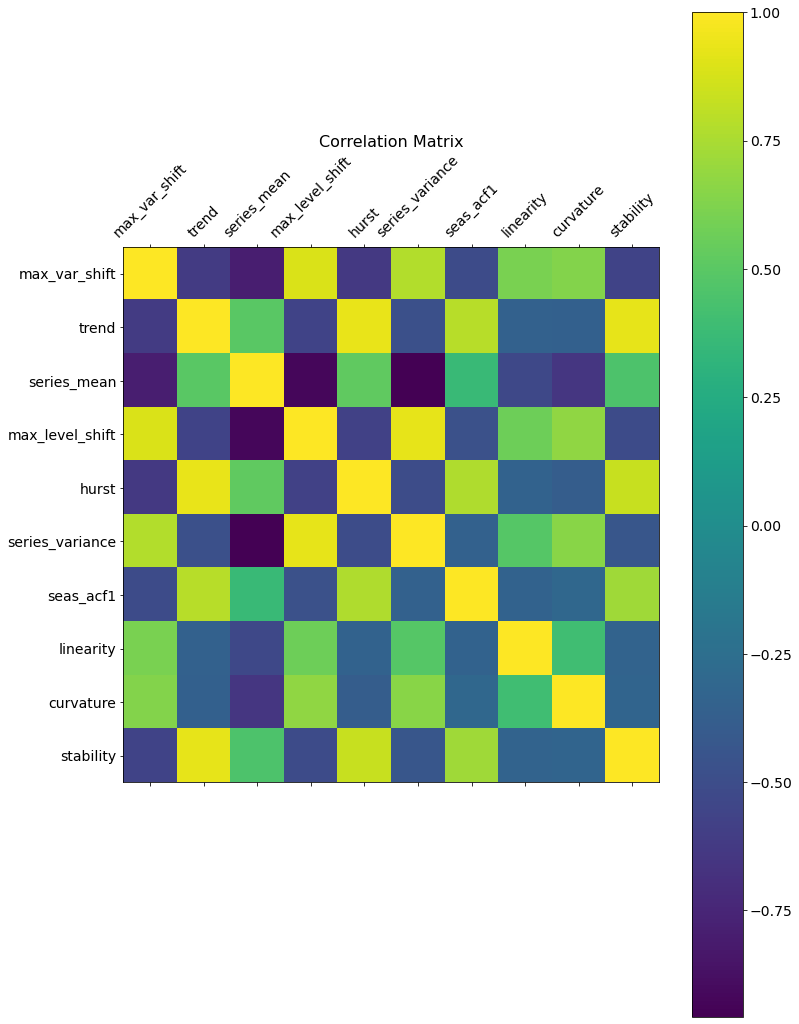

In [51]:
f = plt.figure(figsize=(12, 18))
plt.matshow(X_scaled.loc[:,selected_features].corr(), fignum=f.number)
plt.xticks(range(X_scaled.loc[:,selected_features].select_dtypes(['number']).shape[1]), X_scaled.loc[:,selected_features].select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(X_scaled.loc[:,selected_features].select_dtypes(['number']).shape[1]), X_scaled.loc[:,selected_features].select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

***

## Predicting Adjustment Value Using Random Forest

In [52]:
RF = RandomForestClassifier()

In [53]:
RF.fit(X_scaled.loc[:,selected_features], y)

RandomForestClassifier()

In [54]:
RF.score(X_scaled.loc[:,selected_features], y)

0.7951175406871609

In [55]:
1-np.mean(y)

0.6332730560578661

In [56]:
result = permutation_importance(RF, X_scaled.loc[:,selected_features], y, n_repeats=20)

In [57]:
importance_indices = np.flip(np.argsort(result.importances_mean))

In [58]:
importances = pd.Series(result.importances_mean[importance_indices], index=X_scaled.loc[:,selected_features].columns[importance_indices])

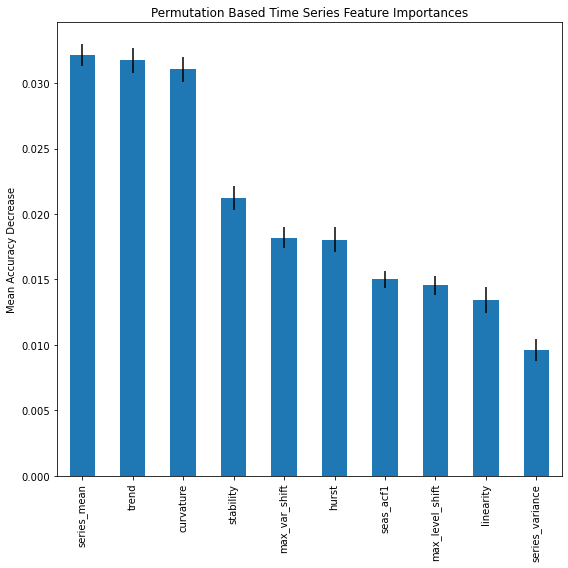

In [60]:
fig, ax = plt.subplots(figsize=(8,8))
importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Permutation Based Time Series Feature Importances")
ax.set_ylabel("Mean Accuracy Decrease")
ax.set_xticklabels(X_scaled.loc[:,selected_features].columns[importance_indices])
fig.tight_layout()
plt.show()

In [61]:
dt_features = X_scaled.loc[:,selected_features].columns[importance_indices][:6]

In [62]:
dt_features

Index(['series_mean', 'trend', 'curvature', 'stability', 'max_var_shift',
       'hurst'],
      dtype='object')

# Marginal Distributions of Important Variables

In [75]:
def marginal_plot(ax1, feature, x_axis_label, y_axis_label_left, y_axis_label_right):
    
    h1 = np.histogram(feature, bins=10)
    
    bin_ids = np.digitize(feature, h1[1])
    
    y_line = pd.concat([pd.Series(bin_ids), y], axis=1).groupby(0).mean()
    
    # fig1, ax1 = plt.subplots(1, 1)
    ax2 = ax1.twinx()
    ax3 = ax2.twiny()

    ax1.hist(feature, alpha=0.5, align='mid', weights=np.ones(len(feature)) / len(feature))

    # ax.plot(y_line)
    ax1.set_xlabel(x_axis_label)
    ax1.set_ylabel(y_axis_label_left)
    ax1.yaxis.set_major_formatter(PercentFormatter(1))

    ax3.plot(y_line)
    ax3.set_xlabel('')
    # note this needs to be ax2 due to subtle overlay issues....
    ax2.set_ylabel(y_axis_label_right)
    ax2.yaxis.set_major_formatter(PercentFormatter(1))

    ax3.axes.get_xaxis().set_ticks([])

    # plt.draw()

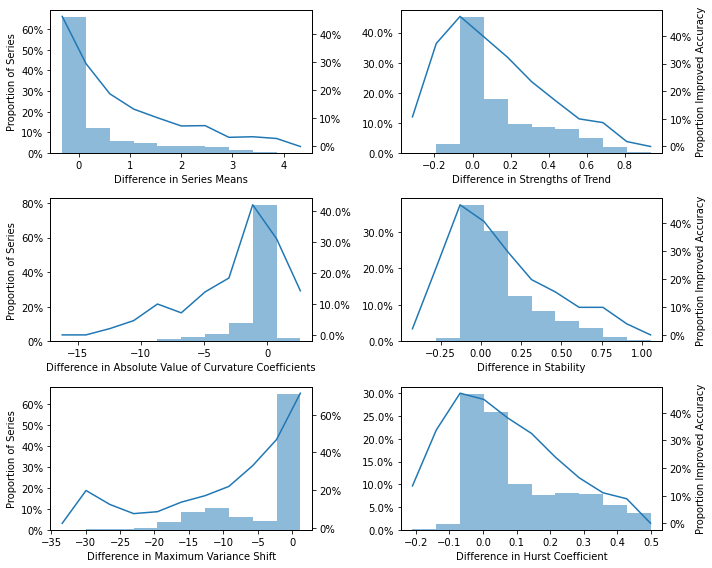

In [86]:
fig, ax = plt.subplots(3, 2, figsize=(10,8))
marginal_plot(ax[0,0], X.series_mean, "Difference in Series Means", "Proportion of Series", "")
marginal_plot(ax[0,1], X.trend, "Difference in Strengths of Trend", "", "Proportion Improved Accuracy")
marginal_plot(ax[1,0], X.curvature, "Difference in Absolute Value of Curvature Coefficients", "Proportion of Series", "")
marginal_plot(ax[1,1], X.stability, "Difference in Stability", "", "Proportion Improved Accuracy")
marginal_plot(ax[2,0], X.max_var_shift, "Difference in Maximum Variance Shift", "Proportion of Series", "")
marginal_plot(ax[2,1], X.hurst, "Difference in Hurst Coefficient", "", "Proportion Improved Accuracy")
plt.tight_layout()

## Explaining Adjustment Value Using Decision Tree

Need to figure out how to generalize decision tree classifications, accounting for series with different lengths.

We extract the most important predictors of whether a privacy adjusted forecast had better accuracy.

In [ ]:
DT = DecisionTreeClassifier(max_depth=3)

In [ ]:
dt_results = DT.fit(X_scaled.loc[:,dt_features], y)

In [ ]:
plt.figure(figsize=(15,10))
plot_tree(DT, filled=True)
plt.title("Decision tree trained on Adjustment Features")
plt.show()

***

Get the leaf indices of each sample.

In [ ]:
leaf_indices = DT.apply(X_scaled.loc[:,dt_features])

Get the leaf indices.

In [ ]:
unique_leaf_indices = np.unique(leaf_indices)

Get the gini impurity of each leaf node.

In [ ]:
gini_leaves = DT.tree_.impurity[unique_leaf_indices]

Get sorted indices of leaf nodes sorted based on gini impurity.

In [ ]:
sorted_leaves = unique_leaf_indices[np.argsort(gini_leaves)]

For each leaf, get the modal outcome.

In [ ]:
[np.mean(y[leaf_indices==x]) for x in sorted_leaves]

In [ ]:
leaves = []
for i in sorted_leaves[:2]:
    leaves.append(X.loc[leaf_indices==i,dt_features]) 

In [ ]:
leaf_means = [x.mean(axis=0) for x in leaves]

Display the mean feature values for the series in each of the leaves with lowest gini.

In [ ]:
leaf_means

Now, plot the average mean-normalized original and protected series in each leaf.

In [ ]:
leaf_orig_series = []
for i in sorted_leaves[:2]:
    leaf_orig_series.append([full_data.loc[k,'original_series'] for k, l in enumerate(leaf_indices) if l==i])
    #leaf_orig_series.append(X.loc[leaf_indices==i,dt_features]) 

In [ ]:
originals = [np.unique(x) for x in leaf_orig_series]

In [ ]:
originals

In [ ]:
originals = [[train_data[x] for x in y] for y in originals]

In [ ]:
lens = np.unique([len(x) for x in originals[0]])

In [ ]:
mean_series = []
for l in lens:
    current_series = [x for x in originals[0] if len(x) == l]
    current_series = pd.concat(current_series, axis=1)
    mean_series.append(current_series.mean(axis=1))

In [ ]:
plot_series(mean_series[0])

In [ ]:
plot_series(mean_series[1])

In [ ]:
lens = np.unique([len(x) for x in originals[1]])

In [ ]:
mean_series = []
for l in lens:
    current_series = [x for x in originals[1] if len(x) == l]
    current_series = pd.concat(current_series, axis=1)
    mean_series.append(current_series.mean(axis=1))

In [ ]:
plot_series(mean_series[0])

In [ ]:
plot_series(mean_series[1])

In [ ]:
plot_series(mean_series[2])

In [ ]:
lens = np.unique([len(x) for x in originals[2]])

In [ ]:
mean_series = []
for l in lens:
    current_series = [x for x in originals[2] if len(x) == l]
    current_series = pd.concat(current_series, axis=1)
    mean_series.append(current_series.mean(axis=1))

In [ ]:
plot_series(mean_series[0])

In [ ]:
plot_series(mean_series[1])